**Random Forest - Classification(Scratch + Visualization)**

**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.preprocessing import label_binarize

**Code**

In [2]:
class Node:
    def __init__(self, *, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0.0
        self.left = None
        self.right = None

    def is_leaf_node(self):
        return self.left is None and self.right is None

In [3]:
class DecisionTree:
    def __init__(self, max_depth=None, max_features=None):
        self.max_depth = max_depth
        self.max_features = max_features

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def predict_proba(self, X):
        return np.array([self._predict_proba(inputs) for inputs in X])

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        impurity = 1 - np.sum([(count / len(y)) ** 2 for count in counts])
        return impurity

    def _best_split(self, X, y):
        m = y.size
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None

        for idx in range(self.n_features_):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

    def _predict_proba(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        prob = np.zeros(self.n_classes_)
        prob[node.predicted_class] = 1.0
        return prob

In [4]:
class RandomForest:
    def __init__(self, n_trees=100, max_depth=None, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.trees = []

        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth, max_features=self.max_features)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Collect predictions from each tree
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Majority vote for classification
        return [Counter(tree_preds[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]

    def predict_proba(self, X):
        # Collect probabilities from each tree
        tree_probs = np.array([tree.predict_proba(X) for tree in self.trees])
        # Average probabilities for classification
        avg_probs = np.mean(tree_probs, axis=0)
        return avg_probs

    def _bootstrap_sample(self, X, y):
        # Generate a random bootstrap sample (sampling with replacement)
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

**Load Dataset**

In [5]:
# Load dataset
iris = load_iris()

# Create a DataFrame
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
# Add the target column for species
df['species'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [6]:
# X = iris.data
# y = iris.target

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
print(X[:5])
print(y[:5])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
[0 0 0 0 0]


In [7]:
print(X.shape), print(y.shape)

(150, 4)
(150,)


(None, None)

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [9]:
# Train the random forest
forest = RandomForest(n_trees=10, max_depth=3, max_features=2)
forest.fit(X_train, y_train)

In [10]:
# Make predictions on the test set
y_pred = forest.predict(X_test)
print(y_pred[:10])

[1, 0, 2, 1, 1, 0, 1, 2, 1, 1]


In [11]:
# Compute the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy}")

Random Forest Accuracy: 1.0


In [12]:
# Making the Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



**Visualization**

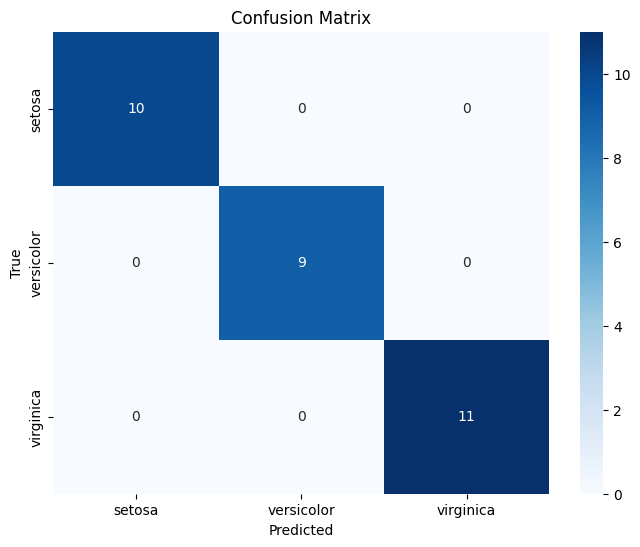

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=iris.target_names, yticklabels=iris.target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)


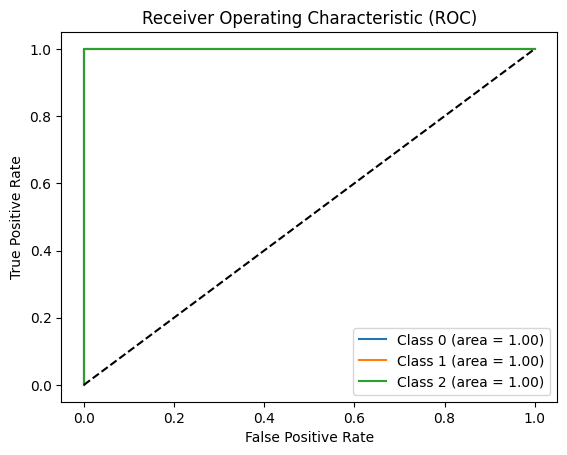

In [14]:
# Compute ROC Curve and AUC

y_prob = forest.predict_proba(X_test)

# Binarize the output for ROC curve computation
y_test_bin = label_binarize(y_test, classes=range(forest.n_classes_))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(forest.n_classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
plt.figure()
for i in range(forest.n_classes_):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

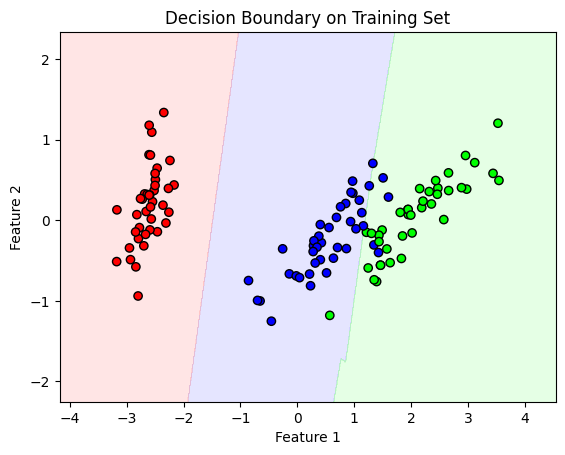

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, title):
    # Project the data to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Define the grid for plotting
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict the class for each point in the grid
    Z = clf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = np.array(Z).reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA']))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k', cmap=ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Visualize the decision boundary
plot_decision_boundary(forest, X_train, y_train, "Decision Boundary on Training Set")


<ipython-input-16-99e3de30d997>:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],


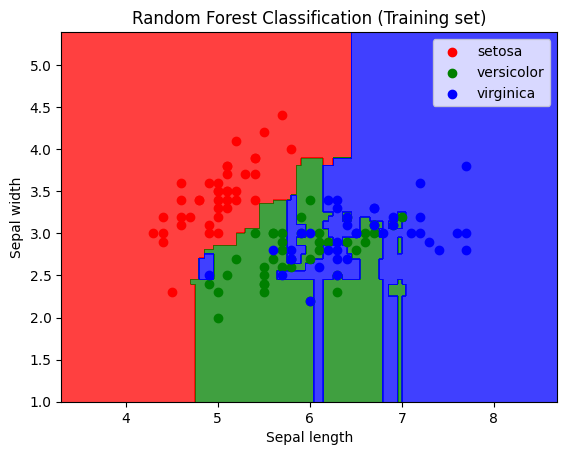

In [16]:
# Limit the training data to the first two features (sepal length and sepal width)
X_train_2D = X_train[:, :2]
X_test_2D = X_test[:, :2]

# Train the Random Forest with only two features
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10, random_state=42)
forest.fit(X_train_2D, y_train)

# Visualizing the decision boundaries using only two features
from matplotlib.colors import ListedColormap
X_set, y_set = X_train_2D, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))

# Plot decision boundaries
plt.contourf(X1, X2, forest.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))

# Plot the training points
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = iris.target_names[j])

plt.title('Random Forest Classification (Training set)')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.legend()
plt.show()

<ipython-input-17-229c8e2d237f>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],


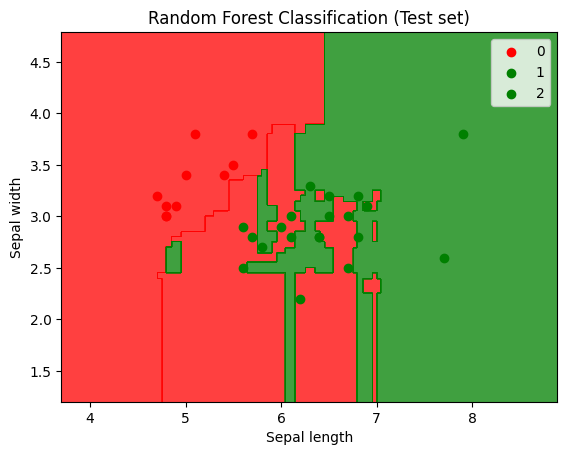

In [17]:
# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, forest.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classification (Test set)')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.legend()
plt.show()

Unique classes in y_test: {0, 1, 2}


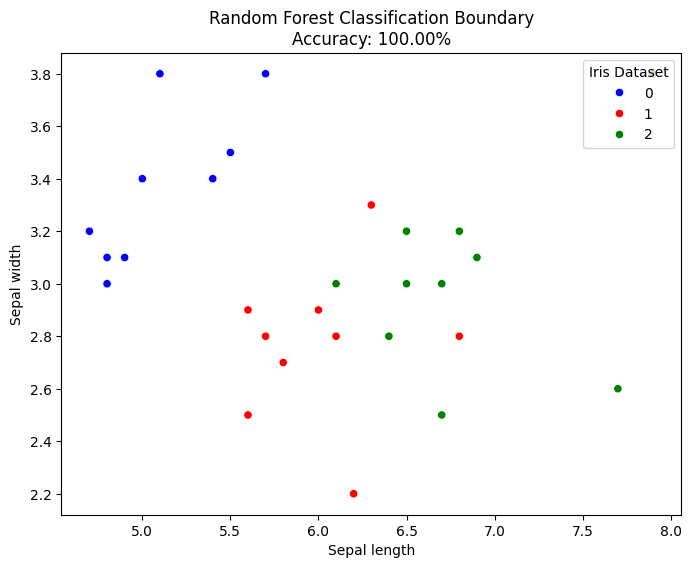

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check unique values in y_test
unique_classes = set(y_test)
print("Unique classes in y_test:", unique_classes)

# Define a palette that includes all classes
palette = {0: 'blue', 1: 'red', 2: 'green'}  # Add more colors if needed

# Visualize the decision boundary with accuracy information
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, palette=palette, marker='o')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title("Random Forest Classification Boundary\nAccuracy: {:.2f}%".format(accuracy * 100))
plt.legend(title="Iris Dataset", loc="upper right")
plt.show()


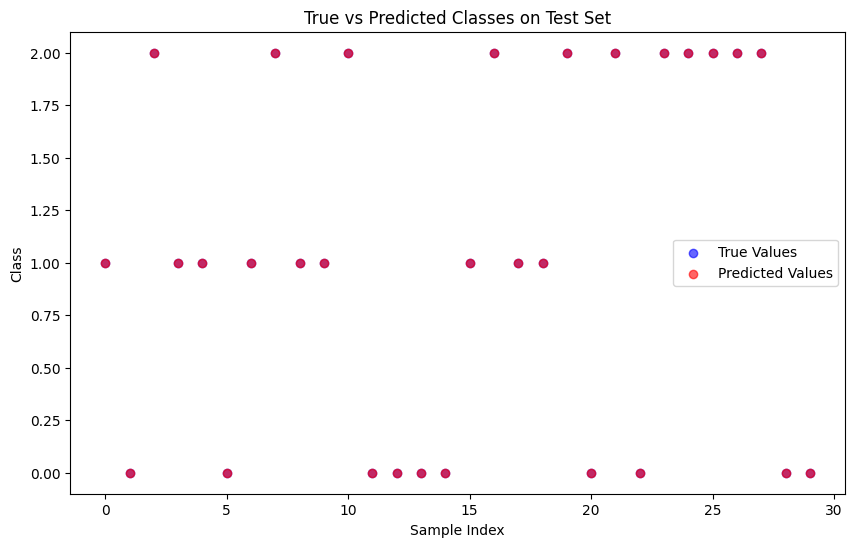

In [19]:
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_true)), y_true, color='blue', label='True Values', alpha=0.6)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values', alpha=0.6)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Class')
    plt.legend()
    plt.show()

# Plot results
plot_results(y_test, y_pred, "True vs Predicted Classes on Test Set")